<center>
<h1>In the name of Allah</h1>
</center>

**Name: Mahdi Saieedi**


**Student Number:401207254**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip uninstall torch torchvision
# !pip install torch torchvision

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm

# A. Load the pretrained Resnet on CIFAR10

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

batch_size = 128

########################## Problem 0 (0  points) ###############################
# todo: Define your data loaders for training and testing                      #
################################################################################

# your code goes here

from torch.utils.data import DataLoader

# Define your data loaders for training and testing
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

################################ End ###########################################


################################ End ###########################################

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

100%|██████████| 170498071/170498071 [00:01<00:00, 102066787.68it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class resnet(nn.Module):
  def __init__(self, num_cls, T=1):
    super().__init__()
    self.conv = nn.Sequential(
        *list(resnet18(weights=None).children())[:-2])

    self.fc = nn.Linear(512, num_cls)
    self.temp = T

  def forward(self, x, T=None):
    if T is None:
      T = self.temp
    x = self.conv(x)
    x = torch.flatten(x, start_dim=1)
    logits = self.fc(x)
    output = torch.softmax(logits / T, dim=1)

    return logits, output

In [ ]:
# Download trained weights of the Resnet18 model on CIFAR10 dataset
!gdown 1KU4jWAwZIq0TUujAsgimLxGWUvwIEfyB

Downloading...
From (original): https://drive.google.com/uc?id=1KU4jWAwZIq0TUujAsgimLxGWUvwIEfyB
From (redirected): https://drive.google.com/uc?id=1KU4jWAwZIq0TUujAsgimLxGWUvwIEfyB&confirm=t&uuid=9908e63b-5b6f-4914-91b4-1fdd24b315eb
To: /content/resnet18_cifar10_model_pretrained.pth
100% 44.8M/44.8M [00:00<00:00, 117MB/s]


In [ ]:
# load trained Resnet18 model on CIFAR10 dataset
model = resnet(len(classes)).to(device)
model_name = "resnet18_cifar10_model_pretrained.pth"
model_PATH = "/content/" + model_name
state_dict = torch.load(model_PATH, map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)

In [ ]:
# def model_normalized(model, inputs):
#     return model(transform_normalize(inputs))

In [ ]:
next(model.parameters()).device

device(type='cpu')

In [ ]:
next(model.parameters()).is_cuda

False

In [ ]:
# pip install --upgrade torch


In [ ]:
# transform_normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [ ]:
# def model_normalized(model, inputs):
#     return model(transform_normalize(inputs))

In [ ]:
def standard_test(model, loader, device=device):
  correct = 0
  total = 0
  ########################## Problem 0 (0 points) ##############################
  # todo: Iterate over loader, compute the output and predicted                #
  # label, and update "correct" and "total" counters accordingly.              #
  ##############################################################################

  # Set the model to evaluation mode
  model.eval()

  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      output = model(images)
      # Check if the model returns a tuple or a single tensor
      if isinstance(output, tuple):
        outputs, _ = output  # Unpack if the output is a tuple
      else:
        outputs = output  # Directly use the output if it's a tensor

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  ################################ End #########################################
  print(f'\n Clean accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
standard_test(model=model, loader= test_loader)


 Clean accuracy of the network on the 10000 test images: 75 %


In [ ]:
standard_test(model=model, loader= train_loader)


 Clean accuracy of the network on the 10000 test images: 100 %


# B. PGD Attack

In [ ]:
# Implement PGD attack

class LinfPGDAttack(object):

    def __init__(self, model, epsilon = 8/255, k = 2, alpha = 2/255):
        self.model = model
        self.epsilon = epsilon
        self.steps = k
        self.alpha = alpha

    def __call__(self, image, label):
        image = image.to(device)
        label = label.to(device)
        outs= self.model(image)
        if isinstance(outs, tuple):
          out, _ = outs  # Unpack if the output is a tuple
        else:
          out = outs
        _, pred = torch.max(out, 1)
        perturbed_image = image.clone()
        perturbed_image.to(device)
        #if pred.item() == label.item():
            ########################## Problem 1 (8 points) ##############################
            # Implement a k step PGD attack of size alpha                                #
            # while always staying within epsilon distance from the initial point        #
            # Use cross entropy loss                                                     #
            ##############################################################################
        loss = nn.CrossEntropyLoss()
        ori_image = image.data
        for i in range(self.steps):
          image.requires_grad = True
          outs = self.model(image)
          if isinstance(outs, tuple):
            out, _ = outs  # Unpack if the output is a tuple
          else:
            out = outs
          self.model.zero_grad()
          cost = loss(out, label).to(device)
          cost.backward()
          adv_image = image + self.alpha*image.grad.sign()
          eta = torch.clamp(adv_image - ori_image, min=-1*self.epsilon, max=self.epsilon)
          image = torch.clamp(ori_image + eta, min=0, max=1).detach_()

        perturbed_image=image



            ################################ End #########################################

        return perturbed_image

In [ ]:
def evalute_pgd(model_input, k_input):
  correct = 0
  total = 0
  model_input.eval()
  pgd = LinfPGDAttack(model_input,k=k_input)
  for data in tqdm(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    adv=pgd(images,labels)
    adv_output = model_input(adv)
    if isinstance(adv_output, tuple):
        adv_outputs, _ = adv_output  # Unpack if the output is a tuple
    else:
        adv_outputs = adv_output  # Directly use the output if it's a tensor
    # print(adv_outputs.size())
    _, predicted = torch.max(adv_outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  print(f'adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k={k_input} : {100 * correct / total} %')


In [ ]:
evalute_pgd(model_input = model, k_input = 2)

100%|██████████| 79/79 [05:09<00:00,  3.92s/it]

adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k=2 : 17.36 %


In [ ]:
########################## Problem 2 (4 points) ##############################
# Evaluate PGD attack on the trained model with k=2,4,8                      #
##############################################################################

k_list = [2,4,8]

##############################################################################


for _k in k_list:
  evalute_pgd(model_input = model  , k_input = _k)



################################ End #########################################

100%|██████████| 79/79 [05:08<00:00,  3.91s/it]


adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k=2 : 17.36 %


100%|██████████| 79/79 [08:56<00:00,  6.79s/it]


adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k=4 : 3.29 %


100%|██████████| 79/79 [16:49<00:00, 12.78s/it]

adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k=8 : 0.95 %


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


the true label is : 3 and the model prediction is : 5
the true label is : 8 and the model prediction is : 0
the true label is : 8 and the model prediction is : 1


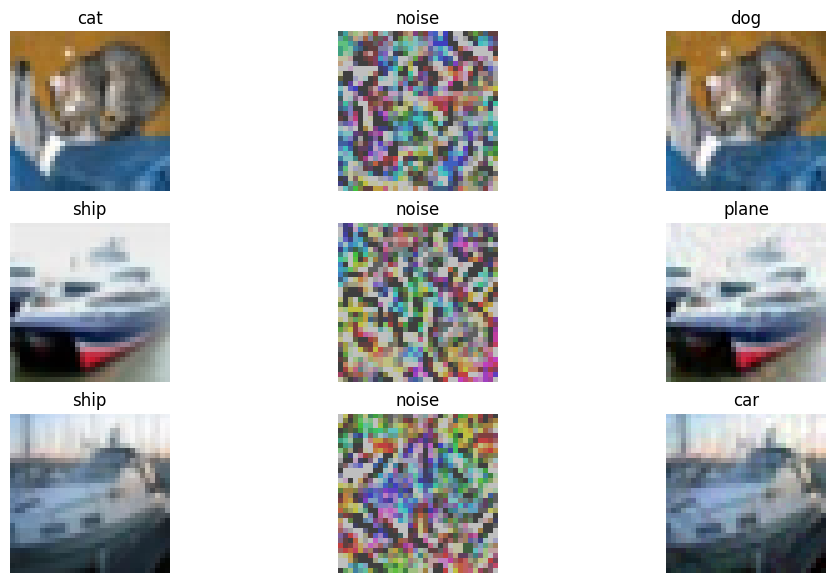

In [ ]:
########################## Problem 3 (4 points) ##############################
# Choose 3 images from the test set that have been incorrectly classified    #
# and plot the actual image, the added noise, and the perturbed image        #
##############################################################################


##############################################################################
import matplotlib.pyplot as plt
model=model.to(device)
newset=torch.utils.data.DataLoader(testset, batch_size = len(testset), shuffle = False, num_workers = 2)
for d,l in newset:
  data=d.to(device)
  targets=l.to(device)

a=[]
model.eval()
pgd=LinfPGDAttack(model,k=4)
for i in tqdm(range(3)):
  adv=pgd(data[i:i+1],targets[i:i+1])
  _,adv_predicted=torch.max(model(adv)[0].data, 1)
  _,true_predicted=torch.max(model(data[i:i+1])[0].data, 1)
  a.append((adv,data[i],adv_predicted[0],true_predicted[0]))


for i in range(3):
  print('the true label is : '+str(a[i][3].item())+' and the model prediction is : '+str(a[i][2].item()))

fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)
for i in range(3):
  adversary_image=np.transpose(a[i][0].detach().cpu().numpy()[0],(1,2,0))
  original_image=np.transpose(a[i][1].detach().cpu().numpy(),(1,2,0))
  plt.subplot(5,3,i*3+1)
  plt.title(classes[a[i][3].item()])
  plt.axis('off')
  plt.imshow(original_image)
  plt.subplot(5,3,i*3+2)
  plt.title('noise')
  plt.axis('off')
  noise=adversary_image-original_image
  plt.imshow(noise/(2*(noise.max()-noise.min()))+0.5)
  plt.subplot(5,3,i*3+3)
  plt.title(classes[a[i][2].item()])
  plt.axis('off')
  plt.imshow(adversary_image)


################################ End #########################################

# C. FGSM Attack

In [ ]:
class FGSMAttack():

    def __init__(self, model):
        self.model = model
        self.adversarials = []
        self.originals = []
        self.predictions = []
        self.confidences = []
        self.truths = []



    def untargeted_fgsm(self, image, epsilon, gradient):

      # Define untargeted fast gradient sign attack pertubation
      # Firstly perturb the image in the proper direction then clamp it between the right values.
      #############################
      # Your code goes here

      sign_data_grad = gradient.sign()

      perturbed_image = image + epsilon*sign_data_grad

      perturbed_image = torch.clamp(perturbed_image, 0, 1)

      return perturbed_image
      #############################

    def __call__(self, image, label, epsilon):


      image = image.to(device)
      label = label.to(device)

      true_image = image.clone()
      image.requires_grad = True
      outs= self.model(image)
      if isinstance(outs, tuple):
        out, _ = outs  # Unpack if the output is a tuple
      else:
        out = outs
      _, pred = torch.max(out, 1)



        # image.requires_grad = True

        # Now define a loss(use the negative log likelihood loss),
        # Zero the gradients of the model parameters and do the backpropagation
        # Retrieve the gradient of the loss with respect to the input image
        # Finally use the function you defined earlier to craft the perturbed image
        #############################
        # Your code goes here
      loss = F.nll_loss(out, label)
      self.model.zero_grad()

      loss.backward()
      image_grad = image.grad.data

      perturbed_image = self.untargeted_fgsm(image, epsilon, image_grad)

      #############################

      outs2 = self.model(perturbed_image)
      if isinstance(outs2, tuple):
        out2, _ = outs2  # Unpack if the output is a tuple
      else:
        out2 = outs2

      _, pred2 = torch.max(out2.data, 1)

      confidence = F.softmax(out2, dim=1)[0][pred2].data

      prob = confidence

      # self.adversarials.append(perturbed_image.squeeze().detach().cpu().numpy())
      # self.originals.append(true_image.squeeze().detach().cpu().numpy())
      # self.predictions.append(pred2.item())
      # self.confidences.append(confidence.item())
      # self.truths.append(label.item())


      return perturbed_image, pred2, confidence, label

In [ ]:
########################## Problem 4 (2 points) ##############################
# Use your implementation from last HW for untargeted FGSM attack            #
##############################################################################

# Your code goes here
#implemented in the last block

################################ End #########################################

In [ ]:
def fgsm_eval(model , epsilon):
  fgsmattack=FGSMAttack(model)
  model.eval()
  correct = 0
  total = 0
  for data in tqdm(test_loader):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      adv,adv_outputs,_,_=fgsmattack(images,labels,epsilon)
      # outputs = model(images)
      predicted =adv_outputs
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f'adversarial Accuracy of ResNet18 model on the 10000 test images with {epsilon} : {100 * correct / total} %')


In [ ]:
########################### Problem 5 (2 points) #############################
# Evaluate untargeted FGSM attack on the trained model with epsilon = 8/255  #
##############################################################################

fgsm_eval(model , 8/255)
################################ End #########################################

100%|██████████| 79/79 [02:46<00:00,  2.10s/it]

adversarial Accuracy of ResNet18 model on the 10000 test images with 0.03137254901960784 : 8.04 %


# D. Adversarial Training

In [ ]:
########################### Problem 6 (1 points) #############################
# Load a new resnet model for adversarial training                           #
##############################################################################

# Your code goes here

adv_model = resnet18(pretrained=True)

################################ End #########################################

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s]


In [ ]:
adv_model = adv_model.to(device)
adv_model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
########################### Problem 6 (6 points) #############################
# Train the model on perturbed images from                                   #
# untargeted FGSM attack with epsilon = 8/255 on train dataset               #
# Also use the following setup for training the model                        #
##############################################################################

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
epochs = 5

##############################################################################

# Your code goes here
fgsmattack=FGSMAttack(model)
for epoch in range(epochs):
    print("epoch " + str(epoch))
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader,0)):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        # outputs = adversary_model(inputs)
        adv,adv_outputs,_,_=fgsmattack(inputs,labels,8/255)
        adv_outputs=adv_model(adv)
        loss = criterion(adv_outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 380 == 1:    # print every 2000 mini-batches #1999
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/380 :.10f}')
            running_loss = 0.0


print('Finished Training')


################################ End #########################################

epoch 0


2it [00:06,  3.14s/it]

[1,     2] loss: 0.0683513717


382it [20:04,  3.01s/it]

[1,   382] loss: 13.6613312219


391it [20:31,  3.15s/it]

epoch 1



2it [00:07,  3.71s/it]

[2,     2] loss: 0.0708030274


382it [19:33,  3.17s/it]

[2,   382] loss: 13.6790821552


391it [20:00,  3.07s/it]

epoch 2



2it [00:06,  3.16s/it]

[3,     2] loss: 0.0723990867


382it [19:34,  3.15s/it]

[3,   382] loss: 13.6687017867


391it [20:02,  3.07s/it]

epoch 3



2it [00:06,  3.11s/it]

[4,     2] loss: 0.0736936745


382it [19:50,  3.10s/it]

[4,   382] loss: 13.6859427302


391it [20:16,  3.11s/it]

epoch 4



2it [00:07,  3.55s/it]

[5,     2] loss: 0.0726644089


382it [19:58,  2.91s/it]

[5,   382] loss: 13.6726972103


391it [20:25,  3.13s/it]

Finished Training


In [ ]:
# save adversary model
adv_model.eval()
model_name = "adversary-resnet18_cifar10_model_std"
CIFAR10_model_PATH = "/content/drive/MyDrive/" + model_name
torch.save(adv_model.state_dict(), CIFAR10_model_PATH)

In [ ]:
# load the adversary model
model_name = "adversary-resnet18_cifar10_model_std"
CIFAR10_model_PATH = "/content/drive/MyDrive/" + model_name
adversary_model = resnet18()
adversary_model.load_state_dict(torch.load(CIFAR10_model_PATH))
adversary_model.eval()
adversary_model = adversary_model.to(device)

In [ ]:
########################### Problem 7 (2 points) #############################
# Evaluate the new model on the test dataset                                 #
##############################################################################
standard_test(adv_model, loader= test_loader)
################################ End #########################################

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



 Clean accuracy of the network on the 10000 test images: 0 %


In [ ]:
########################### Problem 8 (3 points) #############################
#  Run PGD attack on the adversarially trained model with k=2,4,8            #
##############################################################################

k_list = [2,4,8]
for _k in k_list:
  evalute_pgd(model_input = adv_model  , k_input = _k)

##############################################################################

# Your code goes here

################################ End #########################################

  0%|          | 0/79 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 79/79 [04:46<00:00,  2.42s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 79/79 [04:46<00:00,  3.63s/it]


adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k=2 : 0.0 %


100%|██████████| 79/79 [08:14<00:00,  6.26s/it]


adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k=4 : 0.0 %


100%|██████████| 79/79 [15:28<00:00, 11.75s/it]

adversarial Accuracy of new model against pgd attack on the 10000 test images with 8/255 and k=8 : 0.0 %


In [ ]:
########################### Problem 9 (1 points) #############################
# Run FGSM attack on the adversarially trained model with epsilon = 8/255    #
##############################################################################
fgsm_eval(adv_model , 8/255)
################################ End #########################################

100%|██████████| 79/79 [02:11<00:00,  1.66s/it]

adversarial Accuracy of ResNet18 model on the 10000 test images with 0.03137254901960784 : 0.02 %


# E. Analyze Results (5 points)

- Analyze the results for the 3 above cells

Your Answer

# F. Built-In Libraries

Use the following library and run FGSM and PGD attack for CIFAR10 test dataset on the given model and compare the results with your own results


https://adversarial-attacks-pytorch.readthedocs.io/en/latest/index.html

In [ ]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 13.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.wh

In [ ]:
########################### Problem 10 (12 points) #############################
# Run FGSM attack (using library) on the pretrained model for the test dataset #
# Run PGD attack (using library) on the pretrained model for the test dataset  #
################################################################################
import torchattacks

################################ End #########################################

In [ ]:
import torchvision.models as models
model2 = models.resnet18(pretrained=True).eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
fgsm_attack = torchattacks.FGSM(model2, eps=8/255)


In [ ]:
def evaluate_attack(attack):
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Generate adversarial examples
        adv_images = attack(images, labels)

        outputs = model2(adv_images)
        if isinstance(outputs, tuple):  # Check if output is a tuple and extract the logits
            outputs = outputs[0]

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy after attack: {100 * correct / total:.2f}%')

In [ ]:
evaluate_attack(fgsm_attack)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy after attack: 0.00%


In [ ]:
pgd_attack = torchattacks.PGD(model2, eps=0.03, alpha=0.01, steps=40)  # Configure the PGD attack


In [ ]:
evaluate_attack(pgd_attack)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy after attack: 0.00%
